### 1. Import the necessary libraries

In [1]:
# !pip install ViTokenizer
!pip install pyvi

  Using cached pyvi-0.1.1-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached sklearn_crfsuite-0.5.0-py2.py3-none-any.whl.metadata (4.9 kB)
  Using cached python_crfsuite-0.9.11-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.3 kB)
Using cached pyvi-0.1.1-py2.py3-none-any.whl (8.5 MB)
Using cached sklearn_crfsuite-0.5.0-py2.py3-none-any.whl (10 kB)
Using cached python_crfsuite-0.9.11-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)


In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
from keras.utils import to_categorical
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from keras.utils import plot_model
from keras.layers import Embedding
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from pyvi import ViTokenizer
from sklearn.preprocessing import LabelEncoder
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### 2. Data preprocessing

In [3]:
def ReadData(path):
    df=pd.read_csv(path,encoding='utf-8')
    return df['corpus'], df['label']

Read csv

In [4]:
X_train,y_train = ReadData("/content/train_df.csv")
X_test,y_test=ReadData("/content/test_df.csv")

In [5]:
print(X_test[128])

quan_sát bên ngoài thấy chắc_chắn chưa dùng nên chưa nhận_định được chất_lượng tuy_nhiên hàng mua của tki thì yên_tâm hơn hết


In [6]:
print(f"X_Train size:{X_train.shape}")
print(f"y_train size {y_train.shape}")

X_Train size:(11525,)
y_train size (11525,)


Fill na

In [7]:
X_train = X_train.fillna('')  # thay NaN bằng chuỗi rỗng
X_test = X_test.fillna('')

word separation

In [8]:
def wordseparation(comment):
    return [review.split() for review in comment]

In [9]:
X_train=wordseparation(X_train)
X_test=wordseparation(X_test)
print(f"X_Train: {X_train[0:2]}")
print(f"X_test: {X_test[0:2]}")

X_Train: [['hàng', 'chuẩn_thanks', 'mua', 'hàng', 'tiki', 'an_tâm', 'hàng', 'chất_lượng'], ['ốp', 'rất', 'ok', 'nhé']]
X_test: [['dây_cáp', 'nhìn', 'mềm_mại', 'chắc_chắn', 'có_vẻ', 'sẽ', 'không', 'bị', 'gãy', 'vỏ', 'dây', 'chất_lượng', 'thì', 'dùng', '1', 'thời_gian', 'đã', 'có_vẻ', 'ok'], ['very', 'god']]


Create Corpus

In [10]:
def CreateCorpus(Vi):
    tokenizer=Tokenizer(oov_token='<oov>')
    tokenizer.fit_on_texts(Vi)
    return tokenizer

In [11]:
X_train_corpus=CreateCorpus(X_train)
X_test_corpus=CreateCorpus(X_test)
print(X_train_corpus.word_index)
print(X_test_corpus.word_index)

{'<oov>': 1, 'hàng': 2, 'tốt': 3, 'không': 4, 'rất': 5, 'giao': 6, 'nhanh': 7, 'sản_phẩm': 8, 'có': 9, 'dùng': 10, 'mình': 11, 'mua': 12, 'được': 13, 'thì': 14, 'ok': 15, 'chất_lượng': 16, 'nghe': 17, 'chuột': 18, 'và': 19, 'là': 20, 'nhưng': 21, 'đẹp': 22, 'sạc': 23, 'với': 24, 'nên': 25, 'ko': 26, 'shop': 27, 'giá': 28, '1': 29, 'bị': 30, 'cho': 31, 'như': 32, 'ổn': 33, 'đã': 34, 'đúng': 35, 'sử_dụng': 36, 'mới': 37, 'này': 38, 'khá': 39, 'tiki': 40, '2': 41, 'mà': 42, 'tai': 43, 'đóng_gói': 44, 'cũng': 45, 'thấy': 46, 'nhận': 47, 'của': 48, 'chưa': 49, 'để': 50, 'hơn': 51, 'lại': 52, 'hơi': 53, 'khi': 54, 'xài': 55, 'quá': 56, 'trong': 57, 'dây': 58, 'chắc_chắn': 59, 'phải': 60, 'vào': 61, 'cái': 62, 'k': 63, 'kết_nối': 64, 'âm_thanh': 65, 'về': 66, 'tay': 67, 'còn': 68, 'hài_lòng': 69, 'sao': 70, 'rồi': 71, 'vừa': 72, 'cẩn_thận': 73, 'biết': 74, 'bên': 75, 'lần': 76, 'pin': 77, 'sẽ': 78, 'lắm': 79, 'hãng': 80, 'luôn': 81, 'chỉ': 82, 'tiền': 83, 'sau': 84, 'nhiều': 85, 'hay': 86, 'r

In [12]:
print(f"Total Word in Corpus of train: ({len(X_train_corpus.word_index)})")
print(f"Total Word in Corpus of test: ({len(X_test_corpus.word_index)})")

Total Word in Corpus of train: (8913)
Total Word in Corpus of test: (4118)


longest sentence in the training set, longest sentence in the test set

In [13]:
max_sentence_Xtrain= max([len(i) for i in  (X_train)])
print(f"max_sentence_Xtrain:{max_sentence_Xtrain} word")
max_sentence_Xtest=max([len(i) for i in (X_test)])
print(f"max_sentence_Xtest:{max_sentence_Xtest} word")

max_sentence_Xtrain:235 word
max_sentence_Xtest:267 word


Generate input training data by converting words to indexes and performing padding to bring into the model

In [14]:
def Padding(Vi):
    vi_sequence=X_train_corpus.texts_to_sequences(Vi)
    vi_sequence=pad_sequences(vi_sequence,maxlen=max_sentence_Xtest,padding='pre')
    return vi_sequence

In [15]:
X_train=Padding(X_train)
X_test=Padding(X_test)
print(X_train[0])
print(X_test[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

Convert labels to numbers

In [16]:
label_encoder=LabelEncoder()
# Mã hóa các nhãn văn bản thành các giá trị số
y_train_encoded=label_encoder.fit_transform(y_train)
y_test_encoded=label_encoder.transform(y_test)
print(y_train_encoded[0:3])

[2 2 0]


Convert number to one_hot_vector

In [17]:
y_train_one_hot=to_categorical(y_train_encoded)
print(y_train_one_hot[0:3])

[[0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]


### 3.Built Model LSTM

#### 3.1. Design configuration for LSTM network

In [18]:
dropout=0.3
total_word=len(X_train_corpus.word_index)
num_classes=3
embedding_size = 20
num_lstm_units = 7
epochs=10

#### 3.2. Train model

In [19]:
model = Sequential()
model.add(Embedding(input_dim=total_word + 1, output_dim=embedding_size))
model.add(LSTM(units=num_lstm_units, dropout=dropout))
model.add(Dense(units=num_classes, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

history = model.fit(X_train, y_train_one_hot, epochs=epochs, batch_size=32, validation_split=0.2)

Epoch 1/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 45s 126ms/step - categorical_accuracy: 0.7821 - loss: 0.7321 - val_categorical_accuracy: 0.8226 - val_loss: 0.4580
Epoch 2/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 33s 100ms/step - categorical_accuracy: 0.8135 - loss: 0.4347 - val_categorical_accuracy: 0.8655 - val_loss: 0.3761
Epoch 3/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 29s 101ms/step - categorical_accuracy: 0.8830 - loss: 0.3414 - val_categorical_accuracy: 0.8833 - val_loss: 0.3424
Epoch 4/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 44s 111ms/step - categorical_accuracy: 0.9107 - loss: 0.2662 - val_categorical_accuracy: 0.8881 - val_loss: 0.3237
Epoch 5/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 38s 101ms/step - categorical_accuracy: 0.9167 - loss: 0.2326 - val_categorical_accuracy: 0.8902 - val_loss: 0.3244
Epoch 6/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 43s 107ms/step - categorical_accuracy: 0.9270 - loss: 0.2003 - val_categorical_accuracy: 0.8915 - val_loss: 0.3297
Epoch 7/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 30s 103ms/step - categorical_a

Network Architecture

In [20]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 267, 20)        │       178,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 7)              │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            24 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 537,266 (2.05 MB)

 Trainable params: 179,088 (699.56 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 358,178 (1.37 MB)

None


Network Architecture Diagram

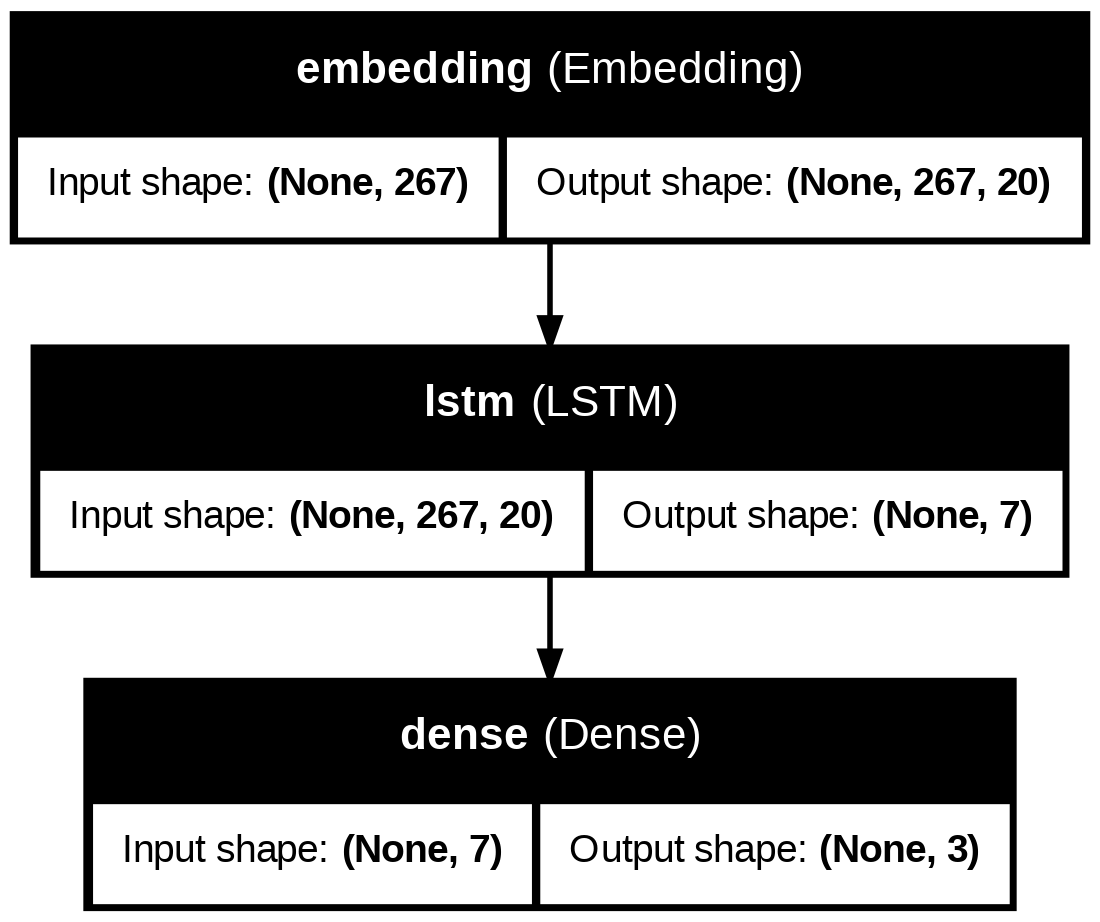

In [21]:
# Tạo đồ thị cho mô hình
plot_model(model, to_file='model_LSTM__sentiment_plot.png', show_shapes=True, show_layer_names=True)

save model

In [22]:
model.save('model_sentiment_lstm.h5')

In [23]:
with open('history_lstm.pkl', 'wb') as file:
    pickle.dump(history.history, file)

#### 3.5 Evaluation test dataset

In [24]:
model_sentiment=load_model("model_sentiment_lstm.h5")

Ploting learning curves:

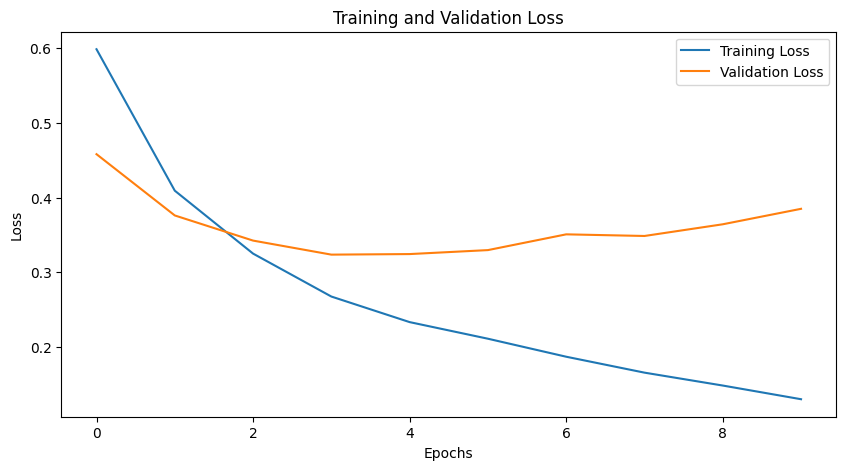

In [25]:
with open('history_lstm.pkl', 'rb') as file:
    history_lstm = pickle.load(file)
plt.figure(figsize=(10, 5))
plt.plot(history_lstm ['loss'], label='Training Loss')
plt.plot(history_lstm ['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Get the weight of the embedding layer

In [26]:
weights = model_sentiment.layers[0].get_weights()[0]

# Giảm chiều dữ liệu sử dụng t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(weights)
print(embeddings_2d[0:2])

[[ 61.174244 -22.99012 ]
 [-20.764769 -10.076573]]


Visualize the context and semantic correlation of words

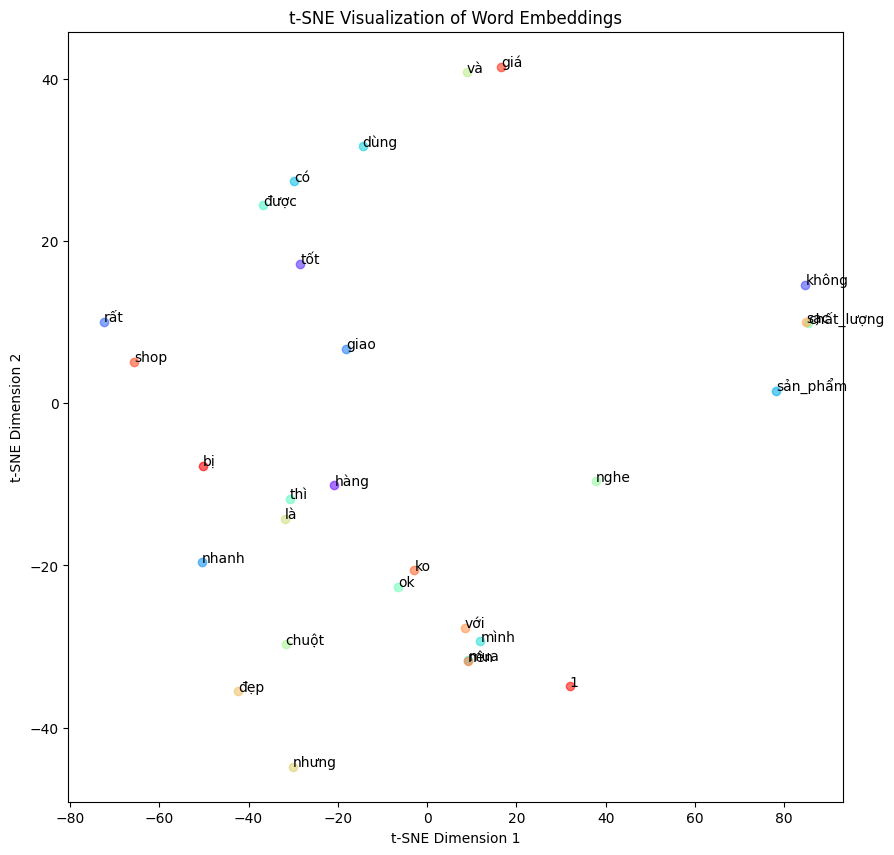

In [27]:
# Vẽ trực quan hóa với nhãn từ
# Màu cho mỗi từ
colors = plt.cm.rainbow(np.linspace(0, 1, 30))
plt.figure(figsize=(10, 10))
for i in range(1,30):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], marker='o', color=colors[i], alpha=0.6)
    plt.annotate(X_train_corpus.index_word[i+1], (embeddings_2d[i, 0], embeddings_2d[i, 1]))
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Word Embeddings')
plt.show()

predict test dataset

In [28]:
result = model_sentiment.predict(X_test)

91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


In [35]:
predict_labels = np.argmax(result,axis=1)

In [29]:
def remove_punctuation(comment):
  # Create a translation table
  translator = str.maketrans('', '', string.punctuation)
  # Remove punctuation
  new_string = comment.translate(translator)
  # Remove redudant space and break sign
  new_string = re.sub('[\n ]+', ' ', new_string)
  # Remove emoji icon
  emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                           "]+", flags=re.UNICODE)
  new_string = re.sub(emoji_pattern, '', new_string)

  return new_string

In [30]:
def read_filestopwords():
    with open('../data/data_stopword/vietnamese-stopwords.txt', 'r', encoding='utf-8') as file:
        lines = file.readlines()
        words = [line.split('\n')[0] for line in lines]
    return words

In [31]:
def remove_stopword(comment):
  stop_words = read_filestopwords()
  filtered = [word for word in comment.split() if word not in stop_words]
  return ' '.join(filtered)

In [32]:
def remove_repeated_words(text):
    words = text.split()
    new_words = []
    for i in range(len(words)):
        if i == 0 or words[i] != words[i-1]:
            new_words.append(words[i])
    return ' '.join(new_words)

In [33]:
def Proprocessing(comment):
    comment= remove_punctuation(comment.lower())
    comment= ViTokenizer.tokenize(comment)
    comment= remove_stopword(comment)
    comment= [remove_repeated_words(comment)]
    comment= wordseparation(comment)
    comment=Padding(comment)
    return comment

Evaluate the model through Accuracy measures,Precision,Recall,F1-score,

In [36]:
accuracy = accuracy_score(y_test_encoded, predict_labels)
print(f'Accuracy: {accuracy:.4f}')

precision = precision_score(y_test_encoded, predict_labels, average='weighted')
print(f"Precision: {precision:.4f}")

recall = recall_score(y_test_encoded, predict_labels, average='weighted')
print(f"Recall: {recall:.4f}")

f1score = f1_score(y_test_encoded, predict_labels, average='weighted')
print(f"F1-score: {f1score}")

Accuracy: 0.8775
Precision: 0.8673
Recall: 0.8775
F1-score: 0.8716636578431153
